Name: Rebecca Kahler

Project Title: Heisman Candidate Prospect and Winner Analysis

github repository: https://github.com/rjkahler/rjkahler.github.io

Data Sources so far: https://www.heisman.com/heisman-winners/, https://www.sports-reference.com/

Project goal: To determine if the Heisman winner is still the objectively best football player in the nation, and has not turned into some sort of popularity contest. Data will be scraped from sources listed above.

In [2]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import math as m
import numpy as np
import  matplotlib.pyplot as plt

In [3]:
def get_player_stats(soup, index):
    all_stats_tables = soup.find_all('div', class_ = 'col-xs-12 col-md-8 col-md-push-2 article-col')
    player_stats = all_stats_tables[-1]

    if len(player_stats.find_all('thead'))==0:
        return 'there was an issue here', index
    else:
        header = player_stats.find_all('thead')[0]
        labels  = header.find_all('th')
        header_text = [thing.text for thing in labels]

        col_info = player_stats.find_all('tbody')[0]
        rows = col_info.find_all('tr')
        rows = [thing.find_all('td') for thing in rows]
        row_text = [thing.text for row in rows for thing in row]

        info = [row_text[k::len(header_text)] for k in range(0,len(header_text))]

        info_dict = dict(zip(header_text, info))
#         info_df = pd.DataFrame.from_dict(info_dict)
        return info_dict

The first website I'm scraping is the Heisman Website because I'm assuming they have the most accurate records for their own award; it will be a good stepping stone at the very least.

In [4]:
winners_web = 'https://www.heisman.com/heisman-winners/'
winners_soup = BeautifulSoup(requests.get(winners_web).text, 'html.parser')

In [5]:
#Grabbing the header of the winners table
header = [thing.text for thing in winners_soup.find_all('div', class_ = 'table_headings')[0].find_all('p')][1:]
header

['Player', 'Year', 'School', 'Pos', 'Class']

Recreating the winner's table:

In [6]:
table = winners_soup.find_all('div', class_ = 'table_roster')[0]
winner_rows  = table.find_all('article')
name = []
year = []
school = []
pos = []
class_ = []
for thing in winner_rows:
    
    name.append(thing.get('data-name'))
    year.append(thing.get('data-year'))
    school.append(thing.get('data-school'))
    pos.append(thing.get('data-position'))
    class_.append(thing.get('data-class'))
    
info_dict = dict(zip(header, [name, year, school, pos, class_]))
info_df = pd.DataFrame.from_dict(info_dict)

Adding a redshirt column:

In [7]:
info_df['redshirt'] = np.where(info_df['Class'].str.contains('\*') == True,1,0)
info_df

,Player,Year,School,Pos,Class,redshirt
0,Jay Berwanger,1935,Chicago,RB,Senior,0
1,Larry Kelley,1936,Yale,TE,Senior,0
2,Clinton Frank,1937,Yale,HB,Senior,0
3,Davey O’Brien,1938,TCU,QB,Senior,0
4,Nile Kinnick,1939,Iowa,RB,Senior,0
...,...,...,...,...,...,...
82,Kyler Murray,2018,Oklahoma,QB,Junior*,1
83,Joe Burrow,2019,LSU,QB,Senior*,1
84,DeVonta Smith,2020,Alabama,WR,Senior,0
85,Bryce Young,2021,Alabama,QB,Sophomore,0


In [8]:
#How many winners had a redshirt status when they won
info_df['redshirt'].sum()

22

In [10]:
#position value counts to get the position groups proportions
info_df.Pos.value_counts(normalize = True)

Pos
RB    0.448276
QB    0.425287
WR    0.045977
TE    0.022989
HB    0.022989
FB    0.022989
CB    0.011494
Name: proportion, dtype: float64

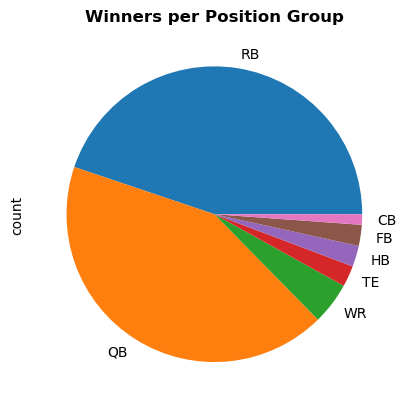

In [9]:
info_df.Pos.value_counts().plot.pie(normalize = True)
plt.title('Winners per Position Group', fontweight = 'bold')
plt.savefig('winner_per_pos.png')
plt.show()

In [33]:
#similar info, but with the first 20 winners...
info_df.head(20).Pos.value_counts()

Pos
RB    11
QB     3
TE     2
HB     2
FB     2
Name: count, dtype: int64

In [34]:
#... and the last twenty winners
info_df.tail(20).Pos.value_counts()

Pos
QB    17
RB     2
WR     1
Name: count, dtype: int64

This next cell makes new urls to scrape to get each winners individual statistics./

In [35]:
#Taking the hyphens out of the names, then collecting the names
info_df['player_string'] = info_df.Player.apply(lambda x: x.replace(' ', '-'))
players = info_df.player_string.to_list()

#making the urls
player_urls = ['https://www.heisman.com/heisman-winners/' + players[k] + '/' for k in range(0,len(players))]

#getting the requests so that we can check them
player_requests = [requests.get(url) for url in player_urls]

Checking the bad urls:

In [36]:
counter = 0
for req in player_requests:
    if req.status_code != 200:
        print('problem with ', player_urls[counter], counter)
    counter = counter + 1

problem with  https://www.heisman.com/heisman-winners/Davey-O’Brien/ 3
problem with  https://www.heisman.com/heisman-winners/Felix-“Doc”-Blanchard/ 10
problem with  https://www.heisman.com/heisman-winners/Carson-Palmer/ 67


Fixing the bad urls:

In [37]:
bad_url = ['https://www.heisman.com/heisman-winners/6721/','https://www.heisman.com/heisman-winners/davey-obrien/',
          'https://www.heisman.com/heisman-winners/felix-doc-blanchard/']
bad_ind = [3,10,67]

for k in range(0,len(bad_ind)):
    ind = bad_ind[k]
    player_requests[ind] = requests.get(bad_url[k])

Getting the player soups. These will allow us to scrape their stats.

In [38]:
player_soups = [BeautifulSoup(req.text, 'html.parser') for req in player_requests]

NOTE: The next few cells will be used in my final prjoect, but not in milestone one. Since I will be using them, I'm leaving them here. My goal is to set up a function that will spit our a stats table for each winner, regardless of position group. I do a few test runs with Caleb Williams, a quarterback, and the Alabama running back that won a few years ago. They were, but there are a few that don't which is why it is broken for now.

In [11]:
# #Looking to get individual statistics. Might be unecessary if we scrape all the data from all players, but it would
# #be a good thing to check and see if data is consistent
url = 'https://www.heisman.com/heisman-winners/caleb-williams/'

# #oh, yeah, we wouldn't need to crawl that

# soup = BeautifulSoup(requests.get(url).text, 'html.parser')

In [40]:
list_of_dicts = [get_player_stats(soup, player_soups.index(soup)) for soup in player_soups]

In [41]:
tups = [x for x in list_of_dicts if type(x) == tuple]
tups
#["*" if i%2==0 else "+" for i in range(6)]

[('there was an issue here', 0),
 ('there was an issue here', 4),
 ('there was an issue here', 29),
 ('there was an issue here', 52)]

In [42]:
#Get these people's statistics elsewhere if possible: Jay Berwanger, Nile Kinnick, John Huarte, Tim Brown

In [43]:
# df_list = []
# for soup in player_soups:    
#     all_stats_tables = soup.find_all('div', class_ = 'col-xs-12 col-md-8 col-md-push-2 article-col')
#     player_stats = all_stats_tables[-1]

#     if len(player_stats.find_all('thead')) > 0:
#         header = player_stats.find_all('thead')[0]
#         labels  = header.find_all('th')
#         header_text = [thing.text for thing in labels]

#         col_info = player_stats.find_all('tbody')[0]
#         rows = col_info.find_all('tr')
#         rows = [thing.find_all('td') for thing in rows]
#         row_text = [thing.text for row in rows for thing in row]

#         info = [row_text[k::len(header_text)] for k in range(0,len(header_text))]

#         info_dict = dict(zip(header_text, info))
#         info_df = pd.DataFrame.from_dict(info_dict)
#         df_list.append(info_df)

In [44]:
# #This is not making any rhyme or reason. We are going to have to fix this dynamically

# #Edit: I think there is actually a bug in the code. Will revist later. 

# player_soups.index(soup)

In [45]:
# all_stats_tables = soup.find_all('div', class_ = 'col-xs-12 col-md-8 col-md-push-2 article-col')
# player_stats = all_stats_tables[-1]


# header = player_stats.find_all('thead')[0]
# labels  = header.find_all('th')
# header_text = [thing.text for thing in labels]

# col_info = player_stats.find_all('tbody')[0]
# rows = col_info.find_all('tr')
# rows = [thing.find_all('td') for thing in rows]
# row_text = [thing.text for row in rows for thing in row]

# info = [row_text[k::len(header_text)] for k in range(0,len(header_text))]

# info_dict = dict(zip(header_text, info))
# info_df = pd.DataFrame.from_dict(info_dict)
# info_df

Individual Player stats:

In [46]:
url = 'https://www.heisman.com/heisman-winners/caleb-williams/'
soup = BeautifulSoup(requests.get(url).text, 'html.parser')

all_stats_tables = soup.find_all('div', class_ = 'col-xs-12 col-md-8 col-md-push-2 article-col')
player_stats = all_stats_tables[-1]


header = player_stats.find_all('thead')[0]
labels  = header.find_all('th')
header_text = [thing.text for thing in labels]

col_info = player_stats.find_all('tbody')[0]
rows = col_info.find_all('tr')
rows = [thing.find_all('td') for thing in rows]
row_text = [thing.text for row in rows for thing in row]

info = [row_text[k::len(header_text)] for k in range(0,len(header_text))]

info_dict = dict(zip(header_text, info))
info_df = pd.DataFrame.from_dict(info_dict)
info_df

,Date,Opponent,Result,Comp,Att,Pct,Yards,YPA,TD,INT,Rushes,Plays,Total Off,YPP,Total TD
0,09/03/22,Rice,W 66-14,19,22,86.4,68,11.3,0,0,6,28,317,11.3,2
1,09/10/22,at Stanford,W 41-28,20,27,74.1,4,12.6,0,0,9,36,345,9.6,4
2,09/17/22,Fresno State,W 45-17,25,37,67.6,1,7.7,2,0,12,49,285,5.8,4
3,09/24/22,at Oregon State,W 17-14,16,36,44.4,27,5.0,0,0,9,45,207,4.6,1
4,10/01/22,Arizona State,W 42-25,27,37,73.0,44,9.4,1,1,8,45,392,8.7,4
5,10/08/22,Wash. State,W 30-14,15,29,51.7,34,6.5,0,0,9,38,222,5.8,2
6,10/15/22,at Utah,L 43-42,25,42,59.5,57,9.1,0,0,8,50,438,8.8,5
7,10/29/22,at Arizona,W 45-37,31,45,68.9,14,9.1,0,0,4,49,425,8.7,5
8,11/05/22,California,W 41-35,26,41,63.4,38,8.8,1,0,7,48,398,8.3,5
9,11/11/22,Colorado,W 55-17,14,26,53.8,-4,10.3,2,1,8,34,264,7.8,5


In [47]:
#Just copy and pasting for now to check
url = 'https://www.heisman.com/heisman-winners/derrick-henry/'

#oh, yeah, we wouldn't need to crawl that

soup = BeautifulSoup(requests.get(url).text, 'html.parser')

all_stats_tables = soup.find_all('div', class_ = 'col-xs-12 col-md-8 col-md-push-2 article-col')
player_stats = all_stats_tables[-1]


header = player_stats.find_all('thead')[0]
labels  = header.find_all('th')
header_text = [thing.text for thing in labels]

col_info = player_stats.find_all('tbody')[0]
rows = col_info.find_all('tr')
rows = [thing.find_all('td') for thing in rows]
row_text = [thing.text for row in rows for thing in row]

info = [row_text[k::len(header_text)] for k in range(0,len(header_text))]

info_dict = dict(zip(header_text, info))
info_df = pd.DataFrame.from_dict(info_dict)
info_df

,Date,Opponent,Result,Att,Yards,YPC,TD,Rec,Yds,Avg,Plays,All-Purpose Yards,YPP,Total TDs
0,09/05/15,+ #23 Wisconsin,W 35-17,13,147,11.31,0,2,12,6.00,15,159,10.6,3
1,09/12/15,Middle Tennessee St,W 37-10,18,96,5.33,0,0,0,0.00,18,96,5.3,3
2,09/09/15,#16 Mississippi,L 37-43,23,127,5.52,0,5,39,7.80,28,166,5.9,1
3,09/26/15,Louisiana-Monroe,W 34-0,13,52,4.00,0,0,0,0.00,13,52,4.0,1
4,10/03/15,at Georgia,W 38-10,26,148,5.69,0,0,0,0.00,26,148,5.7,1
5,10/10/15,Arkansas,W 27-14,27,95,3.52,0,0,0,0.00,27,95,3.5,1
6,10/17/15,at Texas A&M,W 41-23,32,236,7.38,0,1,18,18.00,33,254,7.7,2
7,10/24/15,Tennessee,W 19-14,28,143,5.11,0,0,0,0.00,28,143,5.1,2
8,11/07/15,#22 LSU,W 30-16,38,210,5.53,0,0,0,0.00,38,210,5.5,3
9,11/14/15,at Mississippi State,W 31-6,22,204,9.27,0,1,0,0.00,23,204,8.9,2


In [ ]:
url = 'https://www.sports-reference.com/cfb/years/2022-rushing.html'
soup = BeautifulSoup(requests.get(url).text, 'html.parser')